# Introduction

The sequence of events so far:

* order data
* clean the data to regular 1Min samples
* scan the data for profiles; write these to CSV files
* load in a profile list for a particular site and year

Now we start charting this data. We'll begin with six signals, three each from the CTD and the fluorometer. 
Always we have two possible axes: Depth and time. Most often we chart against depth using the y-axis and 
measuring from a depth of 200 meters at the bottom to the surface at the top of the chart. 


CTD signals

* Temperature
* Salinity
* Dissolved oxygen


Fluorometer signals

* CDOM: Color Dissolved Organic Matter)
* chlor-a: Chlorophyll pigment A
* scatt: Backscatter


The other sensor signals will be introduced subsequently. These include nitrate concentration,
pH, pCO2, PAR, spectral irradiance, local current and water density. 


In [ ]:
# preparation steps

In [1]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../data'

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [12]:
# Create a pandas DataFrame: Six columns of datetimes for a particular year and site
#   The six columns are start/end for, in order: ascent, descent, rest: See column labels below.
def ReadProfiles(fnm):
    """
    Profiles are saved by site and year as 12-tuples. Here we read only
    the datetimes (not the indices) so there are only six values. These
    are converted to Timestamps. They correspond to ascend start/end, 
    descend start/end and rest start/end.
    """
    df = pd.read_csv(fnm, usecols=["1", "3", "5", "7", "9", "11"])
    df.columns=['ascent_start', 'ascent_end', 'descent_start', 'descent_end', 'rest_start', 'rest_end']
    df['ascent_start'] = pd.to_datetime(df['ascent_start'])
    df['ascent_end'] = pd.to_datetime(df['ascent_end'])
    df['descent_start'] = pd.to_datetime(df['descent_start'])
    df['descent_end'] = pd.to_datetime(df['descent_end'])
    df['rest_start'] = pd.to_datetime(df['rest_start'])
    df['rest_end'] = pd.to_datetime(df['rest_end'])
    return df


# FilterSignal() operates on a time series DataArray passed in as 'v'. It is set up to point to multiple possible
#   smoothing kernels but has just one at the moment, called 'hat'.
def FilterSignal(v, ftype='hat', control1=3):
    """Operate on an XArray data array (with some checks) to produce a filtered version"""
    # pre-checks
    if not v.dims[0] == 'time': return v

    if ftype == 'hat': 
        n_passes = control1        # should be a kwarg
        len_v = len(v)
        for n in range(n_passes):
            source_data = np.copy(v) if n == 0 else np.copy(smooth_data)
            smooth_data = [source_data[i] if i == 0 or i == len_v - 1 else \
                0.5 * source_data[i] + 0.25 * (source_data[i-1] + source_data[i + 1]) \
                for i in range(len_v)]
        return smooth_data
    return v


# This is a charting function that uses doubled x-axes; so we get six signals on three charts
def ChartSixOnThree(d00, d01, d02, d0_depth, d10, d11, d12, d1_depth, ranges, titles, subtitles): 
    """
    Chart six signals on three charts using .twiny() to create two coexisting x-axes
    """
    fig, axs = plt.subplots(3,1,figsize=(12, 12), tight_layout=True)
    axsTwin = [axs[i].twiny() for i in range(3)]

    # compare unfiltered example: omits smooth_ qualifier:
    # axs[0].plot(ctd_t + 0.5, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='r')

    axs[0].plot(d00, d0_depth, marker='o', markersize = 2., color='m', markerfacecolor='m')
    axs[1].plot(d01, d0_depth, marker='s', markersize = 2., color='c', markerfacecolor='c')
    axs[2].plot(d02, d0_depth, marker='D', markersize = 2., color='y', markerfacecolor='y')

    axsTwin[0].set_xlabel(subtitles[0], color='g')
    axsTwin[1].set_xlabel(subtitles[1], color='b')
    axsTwin[2].set_xlabel(subtitles[2], color='r')

    axsTwin[0].plot(d10, d1_depth, marker='s', markersize = 2., color='g', markerfacecolor='g')
    axsTwin[1].plot(d11, d1_depth, marker='s', markersize = 2., color='b', markerfacecolor='b')
    axsTwin[2].plot(d12, d1_depth, marker='s', markersize = 2., color='r', markerfacecolor='r')
    axsTwin[0].tick_params(axis='x', labelcolor='g')
    axsTwin[1].tick_params(axis='x', labelcolor='b')
    axsTwin[2].tick_params(axis='x', labelcolor='r')
    
    axs[0].set(xlim = (ranges[0][0], ranges[0][1]), ylim = (200., 0.), title=titles[0])
    axs[1].set(xlim = (ranges[1][0], ranges[1][1]), ylim = (200., 0.), title=titles[1])
    axs[2].set(xlim = (ranges[2][0], ranges[2][1]), ylim = (200., 0.), title=titles[2])
    
    axsTwin[0].set(xlim = (ranges[3][0], ranges[3][1]), ylim = (200., 0.))
    axsTwin[1].set(xlim = (ranges[4][0], ranges[4][1]), ylim = (200., 0.))
    axsTwin[2].set(xlim = (ranges[5][0], ranges[5][1]), ylim = (200., 0.))
    
    return

## Chart a single profile from January 1, 2019

2019-01-01 00:27:00 2019-01-01 01:37:00
...


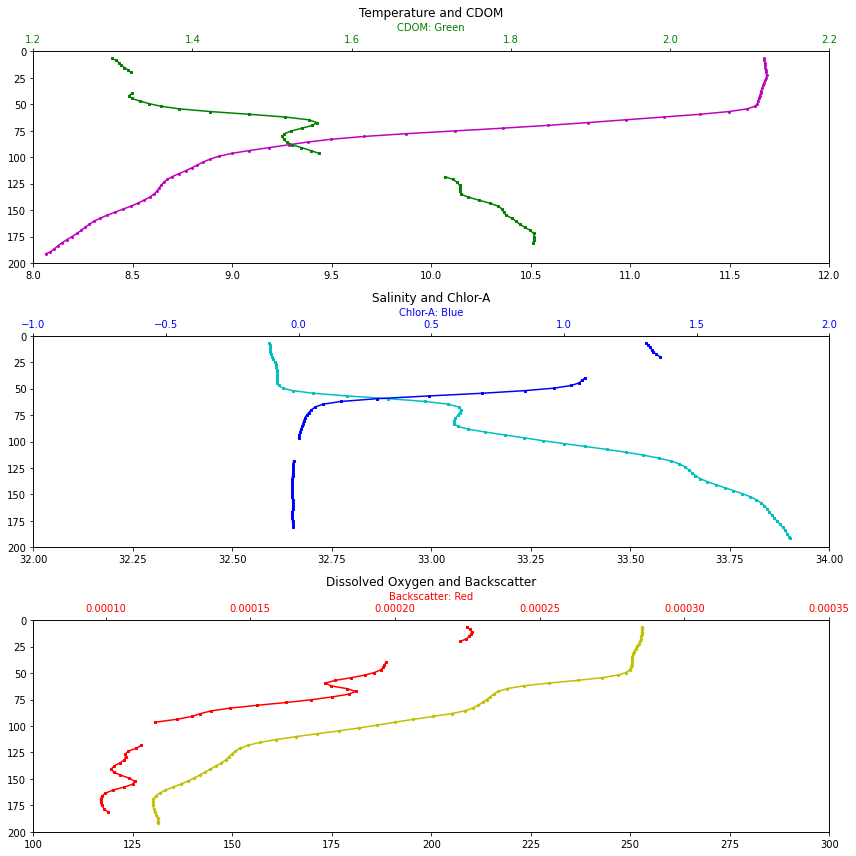

In [14]:
# Read the OSB 2019 profiles list from the CSV file
df = ReadProfiles(os.getcwd() + '/profiles/osb2019.csv')
# access via 'df['descent_end'][2])'


# loading CTD/DO + nitrate + fluorometer by copy/paste from nbk 01 A
ds_CTD = xr.open_dataset("./data/rca/ctd/osb_ctd_jan2019_1min.nc")

nitrate_source = './data/rca/nitrate/'
nitrate_data_midnight = 'nc_midn_2019_01.nc'
nitrate_data_noon     = 'nc_noon_2019_01.nc'

ds_nitrate_midn = xr.load_dataset(nitrate_source + nitrate_data_midnight)
ds_nitrate_noon = xr.load_dataset(nitrate_source + nitrate_data_noon)

fluorometer_source = './data/rca/fluorescence/'
fluorometer_data = 'osb_sp_fluor_jan2019.nc'
ds_Fluorometer = xr.open_dataset(fluorometer_source + fluorometer_data)

time0, time1 = df['ascent_start'][0], df['ascent_end'][0]

print(time0, time1)
ds_CTD_time_slice = ds_CTD.sel(time=slice(time0, time1))
ds_fluor_time_slice = ds_Fluorometer.sel(time=slice(time0, time1))

ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = FilterSignal(ctd_t)
ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = FilterSignal(ctd_s)
ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = FilterSignal(ctd_o)

ctd_d = ds_CTD_time_slice['seawater_pressure']

fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = FilterSignal(fluor_a)
fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = FilterSignal(fluor_c)
fluor_s = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_s = FilterSignal(fluor_s)

fluor_d = ds_fluor_time_slice['int_ctd_pressure']

temperature_lbound, temperature_ubound           =   8.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
chlora_lbound, chlora_ubound                     =  -1.,         2.
scatt_lbound, scatt_ubound                       =   0.000075,    .00035

ranges = []
ranges.append([temperature_lbound, temperature_ubound])
ranges.append([salinity_lbound, salinity_ubound])
ranges.append([dissolved_oxygen_lbound, dissolved_oxygen_ubound])
ranges.append([cdom_lbound, cdom_ubound])
ranges.append([chlora_lbound, chlora_ubound])
ranges.append([scatt_lbound, scatt_ubound])

titles = ['Temperature and CDOM', 'Salinity and Chlor-A', 'Dissolved Oxygen and Backscatter']
subtitles = ['CDOM: Green', 'Chlor-A: Blue', 'Backscatter: Red']
ChartSixOnThree(smooth_ctd_t, smooth_ctd_s, smooth_ctd_o, ctd_d,          \
                smooth_fluor_c, smooth_fluor_a, smooth_fluor_s, fluor_d,  \
                ranges, titles, subtitles)

print('...')

### Side by side selection comparions

In [15]:
# not used at the moment: %matplotlib inline

from ipywidgets import *
from traitlets import dlink

df = ReadProfiles(os.getcwd() + '/profiles/osb2019.csv')
print('Example: Descent end time, table row 2:', df['descent_end'][2])


Example: Descent end time, table row 2: 2019-01-01 06:37:00


In [16]:
# Side-by-side charting of two profiler signals e.g. from different time ranges
#   used by the widget interface that follows
def ProfileChoicesChart(ctd, fluor, t, savefigure = False):
    """
    Left/Right chart comparative: CTD x 3, fluorescence x 3; 
      using time ranges in t[0, 1, 2, 3][i]
      bool savefigure decides a snapshot png written to the home directory
    """
    
    nlr = [len(t[0]), len(t[2])]
    
    # t is a list of four lists so the slow / left index refers as 0, 1, 2, 3 to:
    #   left begin-time, left end-time, right begin-time, right end-time
    # Each of these four elements is a list of times corresponding to multiple profiles
    #   By choosing a slider value > 1 we can overplot sets of consecutive profiles
    
    nLeft = len(t[0])
    if not nLeft == len(t[1]): print('profile count mismatch left side'); return
    nRight = len(t[2])
    if not nRight == len(t[3]): print('profile count mismatch right side'); return
    
    temperature_lbound, temperature_ubound           =   8.,        12.
    salinity_lbound, salinity_ubound                 =  32.,        34.
    dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
    chlora_lbound, chlora_ubound                     =  -1.,         2.
    cdom_lbound, cdom_ubound                         =   1.2,        2.2
    scatt_lbound, scatt_ubound                       =   0.000075,    .00035

    fig, axs = plt.subplots(6, 2, figsize=(15, 15), tight_layout=True)

    for lr in range(2):                           # lr = 0 for left, 1 for right
        for profile_counter in range(nlr[lr]):       # side_counter counts first lefts then rights
        
            # these span across sensors for each (index = 'side_counter') time window
            ctd_slice   = ctd.sel(time=slice(t[lr*2][profile_counter], t[lr*2+1][profile_counter]))
            fluor_slice = fluor.sel(time=slice(t[lr*2][profile_counter], t[lr*2+1][profile_counter]))

            # ctd, fluor breakout into source sensor data
            ctd_t   =   ctd_slice['seawater_temperature']
            ctd_s   =   ctd_slice['practical_salinity']
            ctd_o   =   ctd_slice['corrected_dissolved_oxygen']
            fluor_a = fluor_slice['fluorometric_chlorophyll_a']
            fluor_c = fluor_slice['fluorometric_cdom']
            fluor_s = fluor_slice['total_volume_scattering_coefficient']

            # option: filtered versions, for example: ctd_t_filt   = filter(  ctd_t, 'hat', nf)

            ctd_d   = ctd_slice['seawater_pressure']
            fluor_d = fluor_slice['int_ctd_pressure']

            axs[0][lr].plot(  ctd_t,   ctd_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[1][lr].plot(  ctd_s,   ctd_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[2][lr].plot(  ctd_o,   ctd_d, marker='D', markersize = 4., color='b', markerfacecolor='y')   
            axs[3][lr].plot(fluor_a, fluor_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[4][lr].plot(fluor_c, fluor_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[5][lr].plot(fluor_s, fluor_d, marker='D', markersize = 4., color='b', markerfacecolor='y')

        axs[0][lr].set(xlim = (temperature_lbound, temperature_ubound),           ylim = (200., 0.), title='temperature')
        axs[1][lr].set(xlim = (salinity_lbound, salinity_ubound),                 ylim = (200., 0.), title='salinity')
        axs[2][lr].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')
        axs[3][lr].set(xlim = (chlora_lbound, chlora_ubound),                     ylim = (200., 0.), title='chlorophyll a')
        axs[4][lr].set(xlim = (cdom_lbound, cdom_ubound),                         ylim = (200., 0.), title='cdom')
        axs[5][lr].set(xlim = (scatt_lbound, scatt_ubound),                       ylim = (200., 0.), title='backscatter')
    
    print('left span', str(t[0][0])[:16], 'to', str(t[1][-1])[:16], \
          '  ...    right span', str(t[2][0])[:16], 'to', str(t[3][-1])[:16])
    
    if savefigure:                                   # at the moment this saves outside of the repo: Large image
        homedir = os.getenv("HOME") 
        fig.savefig(homedir + "/profile_comparator_RCA_OSB_SP.png")
    
    return

In [ ]:
def ProfileChoicesThreeByTwo(ctd, fluor, t, ranges, titles, subtitles):
    """
    Left/Right chart comparative: CTD x 3, fluorescence x 3; 
      using t[0, 1, 2, 3] as a list of lists: 0 and 1 for left, 2 and 3 for right
      ranges are tuples (lo, hi) in order: temp, sal, DO, cdom, chlora, scatt
      bool savefigure decides a snapshot png written to the home directory
    """

    nlr = [len(t[0]), len(t[2])]
    
    # t is a list of four lists so the slow / left index refers as 0, 1, 2, 3 to:
    #   left begin-time list, left end-time list, right begin-time list, right end-time list
    #   Each is a list of times corresponding to multiple profiles.
    #   By choosing a slider value > 1 we can overplot sets of consecutive profiles.
    
    nLeft = len(t[0])
    if not nLeft == len(t[1]): print('profile count mismatch left side'); return
    nRight = len(t[2])
    if not nRight == len(t[3]): print('profile count mismatch right side'); return
    
    temperature_lbound, temperature_ubound           =   8.,        12.
    salinity_lbound, salinity_ubound                 =  32.,        34.
    dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
    chlora_lbound, chlora_ubound                     =  -1.,         2.
    cdom_lbound, cdom_ubound                         =   1.2,        2.2
    scatt_lbound, scatt_ubound                       =   0.000075,    .00035

    fig, axs = plt.subplots(15, 15, figsize=(6, 9), tight_layout=True)

    for lr in range(2):                           # lr = 0 for left, 1 for right
        for profile_counter in range(nlr[lr]):       # side_counter counts first lefts then rights
        
            # these span across sensors for each (index = 'side_counter') time window
            ctd_slice   = ctd.sel(time=slice(t[lr*2][profile_counter], t[lr*2+1][profile_counter]))
            fluor_slice = fluor.sel(time=slice(t[lr*2][profile_counter], t[lr*2+1][profile_counter]))

            # ctd, fluor breakout into source sensor data
            ctd_t   =   ctd_slice['seawater_temperature']
            ctd_s   =   ctd_slice['practical_salinity']
            ctd_o   =   ctd_slice['corrected_dissolved_oxygen']
            fluor_a = fluor_slice['fluorometric_chlorophyll_a']
            fluor_c = fluor_slice['fluorometric_cdom']
            fluor_s = fluor_slice['total_volume_scattering_coefficient']

            # option: filtered versions, for example: ctd_t_filt   = filter(  ctd_t, 'hat', nf)

            ctd_d   = ctd_slice['seawater_pressure']
            fluor_d = fluor_slice['int_ctd_pressure']

            axs[0][lr].plot(  ctd_t,   ctd_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[1][lr].plot(  ctd_s,   ctd_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[2][lr].plot(  ctd_o,   ctd_d, marker='D', markersize = 4., color='b', markerfacecolor='y')   
            axs[3][lr].plot(fluor_a, fluor_d, marker='o', markersize = 4., color='k', markerfacecolor='c')
            axs[4][lr].plot(fluor_c, fluor_d, marker='s', markersize = 4., color='g', markerfacecolor='m')
            axs[5][lr].plot(fluor_s, fluor_d, marker='D', markersize = 4., color='b', markerfacecolor='y')

        axs[0][lr].set(xlim = (temperature_lbound, temperature_ubound),           ylim = (200., 0.), title='temperature')
        axs[1][lr].set(xlim = (salinity_lbound, salinity_ubound),                 ylim = (200., 0.), title='salinity')
        axs[2][lr].set(xlim = (dissolved_oxygen_lbound, dissolved_oxygen_ubound), ylim = (200., 0.), title='dissolved oxygen')
        axs[3][lr].set(xlim = (chlora_lbound, chlora_ubound),                     ylim = (200., 0.), title='chlorophyll a')
        axs[4][lr].set(xlim = (cdom_lbound, cdom_ubound),                         ylim = (200., 0.), title='cdom')
        axs[5][lr].set(xlim = (scatt_lbound, scatt_ubound),                       ylim = (200., 0.), title='backscatter')
    
    print('left span', str(t[0][0])[:16], 'to', str(t[1][-1])[:16], \
          '  ...    right span', str(t[2][0])[:16], 'to', str(t[3][-1])[:16])
    
    if savefigure:
        homedir = os.getenv("HOME") 
        fig.savefig(homedir + "/profile_comparator_RCA_OSB_SP.png")
    
    return

In [ ]:
time0, time1 = dt64('2019-01-01T00:26:05'), dt64('2019-01-01T01:37:55')
ds_CTD_time_slice = ds_CTD.sel(time=slice(time0, time1))
ds_fluor_time_slice = ds_Fluorometer.sel(time=slice(time0, time1))

ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = filter(ctd_t)
ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = filter(ctd_s)
ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = filter(ctd_o)

ctd_d = ds_CTD_time_slice['seawater_pressure']

fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = filter(fluor_a)
fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = filter(fluor_c)
fluor_s = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_s = filter(fluor_s)

fluor_d = ds_fluor_time_slice['int_ctd_pressure']

temperature_lbound, temperature_ubound           =   8.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
chlora_lbound, chlora_ubound                     =  -1.,         2.
scatt_lbound, scatt_ubound                       =   0.000075,    .00035

ranges = []
ranges.append([temperature_lbound, temperature_ubound])
ranges.append([salinity_lbound, salinity_ubound])
ranges.append([dissolved_oxygen_lbound, dissolved_oxygen_ubound])
ranges.append([cdom_lbound, cdom_ubound])
ranges.append([chlora_lbound, chlora_ubound])
ranges.append([scatt_lbound, scatt_ubound])

titles = ['Temperature and CDOM', 'Salinity and Chlor-A', 'Dissolved Oxygen and Backscatter']
subtitles = ['CDOM: Green', 'Chlor-A: Blue', 'Backscatter: Red']
ChartSixOnThree(smooth_ctd_t, smooth_ctd_s, smooth_ctd_o, ctd_d,          \
                smooth_fluor_c, smooth_fluor_a, smooth_fluor_s, fluor_d,  \
                ranges, titles, subtitles)

In [ ]:
def SliderRelay(firstLeft, numberLeft, firstRight, numberRight):
    
    global ds_CTD, ds_Fluorometer, nProfiles, ascent_start_indices, ascent_end_indices 
    
    nLeftActual  = min(numberLeft, nProfiles - firstLeft)
    nRightActual = min(numberRight, nProfiles - firstRight)
    
    t_left_start_list  = [dt64(ds_CTD.time[ascent_start_indices[i][0]].data) \
                          for i in range(firstLeft, firstLeft + nLeftActual)]
    t_left_end_list    = [dt64(ds_CTD.time[ascent_end_indices[i][0]].data) \
                          for i in range(firstLeft, firstLeft + nLeftActual)]   
    t_right_start_list = [dt64(ds_CTD.time[ascent_start_indices[i][0]].data) \
                          for i in range(firstRight, firstRight + nRightActual)]
    t_right_end_list   = [dt64(ds_CTD.time[ascent_end_indices[i][0]].data) \
                          for i in range(firstRight, firstRight + nRightActual)]
    
    ProfileChoicesChart(ds_CTD, ds_Fluorometer, 
                        [t_left_start_list, t_left_end_list, t_right_start_list, t_right_end_list], False)

In [5]:
interact(SliderRelay, firstLeft=widgets.IntSlider(min=0, max=nProfiles-1, step=1, value=fLeft0, \
                                          continuous_update=False, description='1st prof left'), \
                      numberLeft=widgets.IntSlider(min=1, max=nProfiles-1, step=1, value=nLeft0, \
                                          continuous_update=False, description='n-prof left'), \
                      firstRight=widgets.IntSlider(min=0, max=nProfiles-1, step=1, value=fRight0, \
                                       continuous_update=False, description='1st prof right'), \
                      numberRight=widgets.IntSlider(min=1, max=nProfiles-1, step=1, value=nRight0, \
                                          continuous_update=False, description='n-prof right')\
        )
               
homedir = os.getenv("HOME")
fig.savefig(homedir + "/profile_comparator_RCA_OSB_SP.png")

NameError: name 'ascent_start_indices' is not defined

### Animating a time series of profiles

We will run the 278 profiles at Oregon Slope Base from January 2019.


In [3]:
# not used: %matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML, Video

In [21]:
df = ReadProfiles('/mnt/d/data/data_explorer_1Min/profiles/osb2019.csv')
print('Example: Descent end time, table row 2:', df['descent_end'][2])

Example: Descent end time, table row 2: 2019-01-01 06:37:00


In [32]:
temperature_lbound, temperature_ubound           =   7.,        12.
salinity_lbound, salinity_ubound                 =  32.,        34.
dissolved_oxygen_lbound, dissolved_oxygen_ubound = 100.,       300.
chlora_lbound, chlora_ubound                     =  -1.,         2.
cdom_lbound, cdom_ubound                         =   1.2,        2.2
scatt_lbound, scatt_ubound                       =   0.000075,    .00035
pressure_lbound, pressure_ubound                 = 200.,         0.

frame_number_global      = 0
frames_to_animate_global = 2              # 278 max

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(3, 2, figsize=(12,8), tight_layout=True)

ax[0][0].set_xlim((temperature_lbound, temperature_ubound))
ax[1][0].set_xlim((salinity_lbound, salinity_ubound))
ax[2][0].set_xlim((dissolved_oxygen_lbound, dissolved_oxygen_ubound))
ax[0][1].set_xlim((chlora_lbound, chlora_ubound))
ax[1][1].set_xlim((cdom_lbound, cdom_ubound))
ax[2][1].set_xlim((scatt_lbound, scatt_ubound))

ax[0][0].set_title('temperature')
ax[1][0].set_title('salinity')
ax[2][0].set_title('dissolved oxygen')
ax[0][1].set_title('chlorophyll a')
ax[1][1].set_title('CDOM')
ax[2][1].set_title('scattering coefficient')

for n in range(3): 
    for m in range(2):
        ax[n][m].set_ylim((pressure_lbound, pressure_ubound))

# .plot() returns a tuple of length 1 so we de-reference this using the trailing [0]
line = [ax[0][0].plot([], [], lw=1, marker='o', ms = 6., c='xkcd:neon purple', mfc='xkcd:salmon pink')[0], \
        ax[1][0].plot([], [], lw=1, marker='s', ms = 6., c='xkcd:barney', mfc='xkcd:emerald')[0], \
        ax[2][0].plot([], [], lw=1, marker='D', ms = 6., c='xkcd:bronze', mfc='xkcd:orange brown')[0], \
        ax[0][1].plot([], [], lw=1, marker='p', ms = 6., c='xkcd:lime green', mfc='xkcd:deep pink')[0], \
        ax[1][1].plot([], [], lw=1, marker='v', ms = 6., c='xkcd:gold', mfc='xkcd:cherry red')[0], \
        ax[2][1].plot([], [], lw=1, marker='h', ms = 6., c='xkcd:tangerine', mfc='xkcd:bright sky blue')[0], \
       ]

# print(type(line), type(line[0]), 'first stop')

# initialization function: plot the background of each frame
def AnimateInit():
    # print(type(line[0]))
    line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    line[3].set_data([], [])
    line[4].set_data([], [])
    line[5].set_data([], [])
    return line
    # was return (line0, line1,)

    
# animation function. This is called sequentially
def AnimateChart(i):
    
    time0, time1 = df['ascent_start'][i], df['ascent_end'][i]
    ds_CTD_time_slice   =         ds_CTD.sel(time=slice(time0, time1))
    ds_fluor_time_slice = ds_Fluorometer.sel(time=slice(time0, time1))

    ctd_t = ds_CTD_time_slice['seawater_temperature'];       smooth_ctd_t = FilterSignal(ctd_t)
    ctd_s = ds_CTD_time_slice['practical_salinity'];         smooth_ctd_s = FilterSignal(ctd_s)
    ctd_o = ds_CTD_time_slice['corrected_dissolved_oxygen']; smooth_ctd_o = FilterSignal(ctd_o)

    ctd_d = ds_CTD_time_slice['seawater_pressure']

    fluor_a = ds_fluor_time_slice['fluorometric_chlorophyll_a'];          smooth_fluor_a = FilterSignal(fluor_a)
    fluor_c = ds_fluor_time_slice['fluorometric_cdom'];                   smooth_fluor_c = FilterSignal(fluor_c)
    fluor_s = ds_fluor_time_slice['total_volume_scattering_coefficient']; smooth_fluor_s = FilterSignal(fluor_s)

    fluor_d = ds_fluor_time_slice['int_ctd_pressure']

    # axs[0][0].plot(smooth_ctd_t, ctd_d, marker='o', markersize = 6., color='k', markerfacecolor='c')
    # axs[0][0].set(xlim = (temperature_lbound, temperature_ubound), ylim = (200., 0.), title='temperature')

    line[0].set_data(smooth_ctd_t, ctd_d)
    line[1].set_data(smooth_ctd_s, ctd_d)
    line[2].set_data(smooth_ctd_o, ctd_d)
    line[3].set_data(smooth_fluor_a, fluor_d)
    line[4].set_data(smooth_fluor_c, fluor_d)
    line[5].set_data(smooth_fluor_s, fluor_d)

    global frame_number_global, frames_to_animate
    frame_number_global += 1
    clear_output(wait = True)
    print("animating frame", frame_number_global, 'of', frames_to_animate_global)
        
    return line
    # was return (line0, line1,)

# call the animator. blit=True means only re-draw the parts that have changed.
# turned off while working elsewhere
if False:
    anim = animation.FuncAnimation(fig, AnimateChart, init_func=AnimateInit, \
                                   frames=frames_to_animate_global, interval=100, blit=True, repeat=False)
    HTML(anim.to_html5_video())

In [29]:
anim.save(os.getenv("HOME") + '/Anim_CTD_and_Fluor_RCA_OSB_SP.mp4')

animating frame 556 of 278


In [4]:
Video(os.getenv("HOME") + '/Anim_CTD_and_Fluor_RCA_OSB_SP.mp4', embed=True)           
# Above: can include , embed=True or use line magic %matplotlib inline